In [83]:
import numpy as np
from numpy.linalg import inv as inv
import matplotlib.pyplot as plt

def ten2mat(tensor, mode):
    return np.reshape(np.moveaxis(tensor, mode, 0), (tensor.shape[mode], -1), order = 'F')

def mat2ten(mat, tensor_size, mode):
    index = list()
    index.append(mode)
    for i in range(tensor_size.shape[0]):
        if i != mode:
            index.append(i)
    return np.moveaxis(np.reshape(mat, list(tensor_size[index]), order = 'F'), 0, mode)

def svt_tnn(mat, alpha, rho, theta):
    tau = alpha / rho
    [m, n] = mat.shape
    if 2 * m < n:
        u, s, v = np.linalg.svd(mat @ mat.T, full_matrices = 0)
        s = np.sqrt(s)
        idx = np.sum(s > tau)
        mid = np.zeros(idx)
        mid[:theta] = 1
        mid[theta:idx] = (s[theta:idx] - tau) / s[theta:idx]
        return (u[:, :idx] @ np.diag(mid)) @ (u[:, :idx].T @ mat)
    
    elif m > 2 * n:
        return svt_tnn(mat.T, tau, theta).T
    
    u, s, v = np.linalg.svd(mat, full_matrices = 0)
    idx = np.sum(s > tau)
    vec = s[:idx].copy()
    vec[theta:idx] = s[theta:idx] - tau
    return u[:, :idx] @ np.diag(vec) @ v[:idx, :]

def compute_rmse(var, var_hat):
    return np.sqrt(np.sum((var - var_hat) ** 2) / var.shape[0])
def compute_mape(var, var_hat):
    return np.sum(np.abs(var - var_hat) / var) / var.shape[0]

def plot(rmse,mape,dataset,missing_rate,mode,duration):

    fig = plt.figure(figsize=(6, 5))
    plt.rc('font',family='Times New Roman')
    ax1= fig.add_subplot(111)
    ax1.plot(mape,label='MAPE')
    
    ax2=ax1.twinx()
    ax2.plot(rmse,color='orange',label='RMSE')
    plt.title('%s - %s - %.1f ' %(mode,dataset,missing_rate),size=15)
    ax1.text( 0.4,0.4, ' MAPE(min): %.3f  loc: %d \n RMSE(min): %.3f  loc: %d \n \n MAPE(last): %.3f  loc: %d \n RMSE(last): %.3f  loc: %d \n Duration: %d seconds' 
             %(mape.min()*100, mape.argmin(), rmse.min(), rmse.argmin(), mape[-1]*100,mape.shape[0], rmse[-1],rmse.shape[0], duration), transform=ax1.transAxes, size=15 )
    ax1.legend(loc='upper left',fontsize=14)
    ax2.legend(loc='upper right',fontsize=14)
    ax1.set_xlim(-10,210)

def LRTC(dense_tensor, sparse_tensor, alpha, rho, theta, epsilon, maxiter):
    """Low-Rank Tenor Completion with Truncated Nuclear Norm, LRTC-TNN.
    """
    dim = np.array(sparse_tensor.shape)
    pos_missing = np.where(sparse_tensor == 0)
    pos_test = np.where((dense_tensor != 0) & (sparse_tensor == 0))
    X = np.zeros(np.insert(dim, 0, len(dim))) # \boldsymbol{\mathcal{X}}
    T = np.zeros(np.insert(dim, 0, len(dim))) # \boldsymbol{\mathcal{T}}
    Z = sparse_tensor.copy()
    last_tensor = sparse_tensor.copy()
    snorm = np.sqrt(np.sum(sparse_tensor ** 2))
    
    ## RMSE and MAPE
    RMSE = np.zeros(maxiter)
    MAPE = np.zeros(maxiter)
    it = 0
    while True:
        rho = min(rho * 1.05, 1e5)
        for k in range(len(dim)):
            
            mat = ten2mat(Z - T[k] / rho, k)
            
            tmat = svt_tnn(mat, alpha[k], rho, np.int(np.ceil(theta * dim[k])))
            
            X[k] = mat2ten(tmat, dim, k)
            
        Z[pos_missing] = np.mean(X + T / rho, axis = 0)[pos_missing]
        T = T + rho * (X - np.broadcast_to(Z, np.insert(dim, 0, len(dim))))
        tensor_hat = np.einsum('k, kmnt -> mnt', alpha, X)
        tol = np.sqrt(np.sum((tensor_hat - last_tensor) ** 2)) / snorm
        last_tensor = tensor_hat.copy()
        
        mape = compute_mape(dense_tensor[pos_test], tensor_hat[pos_test])
        rmse = compute_rmse(dense_tensor[pos_test], tensor_hat[pos_test])
        MAPE[it] = mape
        RMSE[it] = rmse
        
        
        it += 1
        if (it + 1) % 100 == 0:
            print('Iter: {}'.format(it + 1))
            print('RMSE: {:.6}'.format(rmse))
            print()
        if (tol < epsilon) or (it >= maxiter):
            break

    print('Imputation MAPE: {:.6}'.format(mape))
    print('Imputation RMSE: {:.6}'.format(rmse))
    print()
    
    return tensor_hat,MAPE[:it],RMSE[:it]

In [84]:
import warnings
warnings.filterwarnings('ignore')

### Experiments on Guangzhou Data Set

#### Random missing (RM) scenario

In [90]:
import scipy.io
def G_RM_(ms):
    ''' ms: missing_rate'''
    dense_tensor = scipy.io.loadmat('../datasets/Guangzhou-data-set/tensor.mat')['tensor']
    random_tensor = scipy.io.loadmat('../datasets/Guangzhou-data-set/random_tensor.mat')['random_tensor']
    binary_tensor = np.round(random_tensor + 0.5 - ms)
    sparse_tensor = np.multiply(dense_tensor, binary_tensor)
    
    import time
    start = time.time()
    alpha = np.ones(3) / 3
    rho = 1e-5
    theta = 0.30
    epsilon = 1e-4
    maxiter = 200
    L, MAPE,RMSE = LRTC(dense_tensor, sparse_tensor, alpha, rho, theta, epsilon, maxiter)
    end = time.time()
    plot(RMSE,MAPE,'G',ms,'RM',end - start)
    print('Running time: %d seconds'%(end - start))

Iter: 100
RMSE: 2.8773

Imputation MAPE: 0.0670164
Imputation RMSE: 2.88087

Running time: 86 seconds


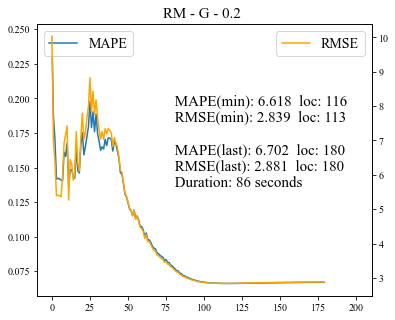

In [43]:
G_RM_(0.2)

Iter: 100
RMSE: 3.14578

Imputation MAPE: 0.0732347
Imputation RMSE: 3.16691

Running time: 93 seconds


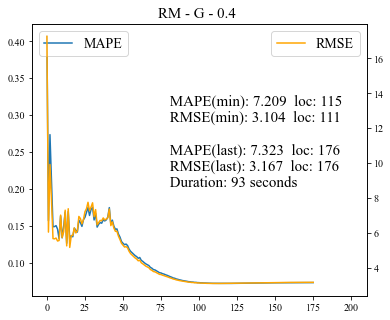

In [44]:
G_RM_(0.4)

Iter: 100
RMSE: 3.43917

Imputation MAPE: 0.0811862
Imputation RMSE: 3.51235

Running time: 97 seconds


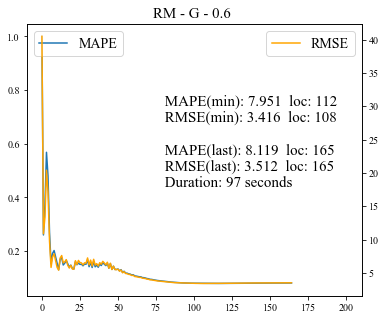

In [45]:
G_RM_(0.6)

Imputation MAPE: 1.0
Imputation RMSE: 40.4839

Running time: 1 seconds


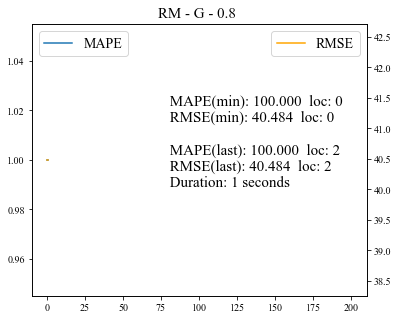

In [46]:
G_RM_(0.8)

#### Non-random missing (NM) scenario

In [47]:
import scipy.io
def G_NM_(ms):
    dense_tensor = scipy.io.loadmat('../datasets/Guangzhou-data-set/tensor.mat')['tensor'].transpose(0, 2, 1)
    dim1, dim2, dim3 = dense_tensor.shape
    np.random.seed(1000)
    sparse_tensor = dense_tensor * np.round(np.random.rand(dim1, dim3) + 0.5 - missing_rate)[:, None, :]

    import time
    start = time.time()
    alpha = np.ones(3) / 3
    rho = 1e-5
    theta = 0.05
    epsilon = 1e-4
    maxiter = 200
    L, MAPE,RMSE = LRTC(dense_tensor, sparse_tensor, alpha, rho, theta, epsilon, maxiter)
    end = time.time()
    plot(RMSE,MAPE,'G',ms,'NM',end - start)
    print('Running time: %d seconds'%(end - start))

Iter: 100
RMSE: 4.00084

Imputation MAPE: 0.0952459
Imputation RMSE: 4.00616

Running time: 70 seconds


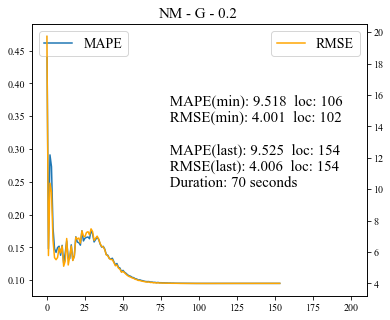

In [48]:
G_NM_(0.2)

Iter: 100
RMSE: 4.08356

Imputation MAPE: 0.0961047
Imputation RMSE: 4.09128

Running time: 85 seconds


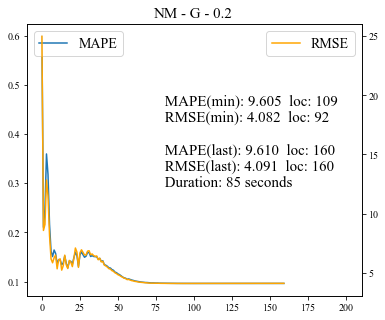

In [49]:
G_NM_(0.4)

Iter: 100
RMSE: 4.21107

Imputation MAPE: 0.0987658
Imputation RMSE: 4.21937

Running time: 96 seconds


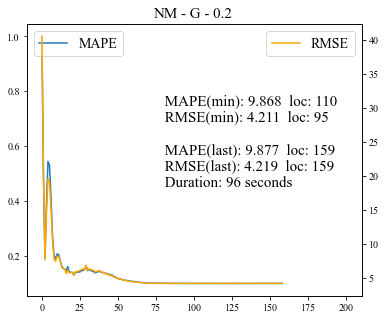

In [50]:
G_NM_(0.6)

Iter: 100
RMSE: 4.45436

Imputation MAPE: 0.105572
Imputation RMSE: 4.47934

Running time: 97 seconds


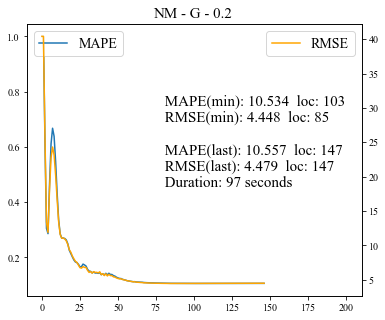

In [51]:
G_NM_(0.8)

### Experiments on PeMS Data Set

#### Random missing (RM) scenario

In [52]:
import scipy.io
import time
import pandas as pd

def P_RM_(ms):
    dense_mat = np.load('../datasets/PeMS-data-set/pems.npy')
    random_tensor = np.load('../datasets/PeMS-data-set/random_tensor.npy')

    ### Random missing (RM) scenario:
    binary_tensor = np.round(random_tensor + 0.5 - missing_rate)
    sparse_mat = np.multiply(dense_mat, ten2mat(binary_tensor, 0))

    sparse_tensor = mat2ten(sparse_mat, np.array(binary_tensor.shape), 0)
    dense_tensor = mat2ten(dense_mat, np.array(binary_tensor.shape), 0)

    del dense_mat, random_tensor, binary_tensor
    
    start = time.time()
    alpha = np.ones(3) / 3
    rho = 1e-5
    theta = 0.15
    epsilon = 1e-4
    maxiter = 200
    L, MAPE,RMSE = LRTC(dense_tensor, sparse_tensor, alpha, rho, theta, epsilon, maxiter)
    end = time.time()
    plot(RMSE,MAPE,'P',ms,'RM',end - start)
    print('Running time: %d seconds'%(end - start))

Iter: 100
RMSE: 2.25261

Imputation MAPE: 0.0319392
Imputation RMSE: 2.26055

Running time: 119 seconds


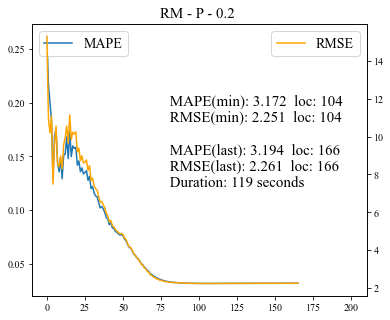

In [53]:
P_RM_(0.2)

Iter: 100
RMSE: 2.70574

Imputation MAPE: 0.0383996
Imputation RMSE: 2.71653

Running time: 123 seconds


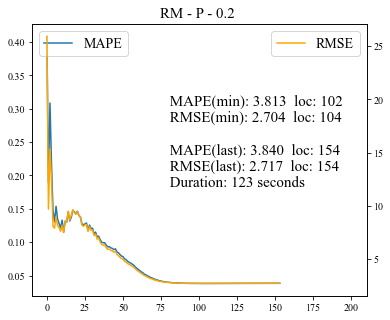

In [54]:
P_RM_(0.4)

Iter: 100
RMSE: 3.36673

Imputation MAPE: 0.0477468
Imputation RMSE: 3.37199

Running time: 126 seconds


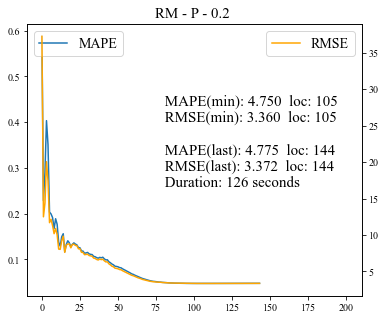

In [55]:
P_RM_(0.6)

Iter: 100
RMSE: 4.43596

Imputation MAPE: 0.0641163
Imputation RMSE: 4.45658

Running time: 146 seconds


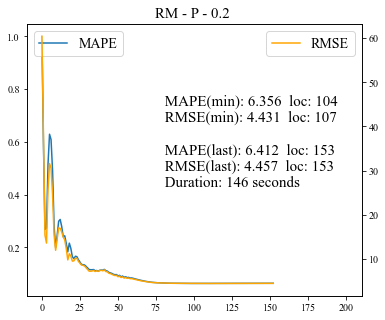

In [56]:
P_RM_(0.8)

#### Non-random missing (NM) scenario

In [57]:

def P_NM_(ms):
    dense_mat = np.load('../datasets/PeMS-data-set/pems.npy')
    dense_tensor = mat2ten(dense_mat, np.array([228,288,44]), 0)
    dim1, dim2, dim3 = dense_tensor.shape
    np.random.seed(1000)
    sparse_tensor = dense_tensor * np.round(np.random.rand(dim1, dim3) + 0.5 - missing_rate)[:, None, :]
    
    start = time.time()
    alpha = np.ones(3) / 3
    rho = 1e-5
    theta = 0.10
    epsilon = 1e-4
    maxiter = 200
    L, MAPE,RMSE = LRTC(dense_tensor, sparse_tensor, alpha, rho, theta, epsilon, maxiter)
    end = time.time()
    plot(RMSE,MAPE,'P',ms,'NM',end - start)
    print('Running time: %d seconds'%(end - start))

Iter: 100
RMSE: 4.93602

Imputation MAPE: 0.0693094
Imputation RMSE: 4.96142

Running time: 106 seconds


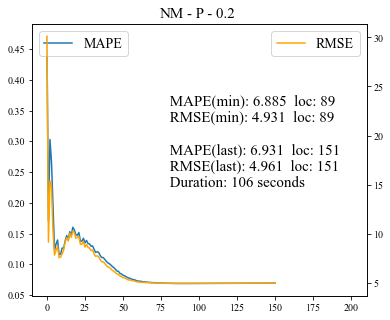

In [58]:
P_NM_(0.2)

Iter: 100
RMSE: 5.41477

Imputation MAPE: 0.0783021
Imputation RMSE: 5.4491

Running time: 124 seconds


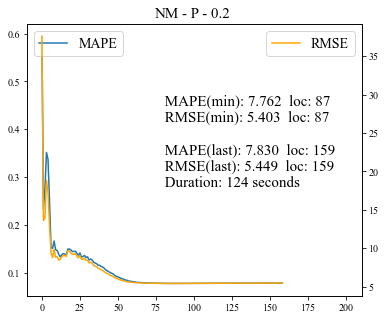

In [59]:
P_NM_(0.4)

Iter: 100
RMSE: 5.92128

Imputation MAPE: 0.0877722
Imputation RMSE: 5.97379

Running time: 141 seconds


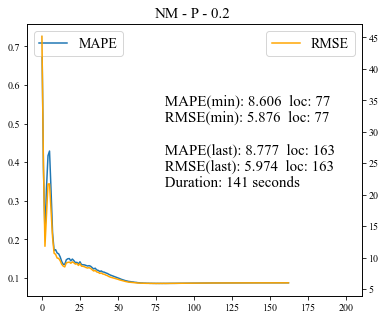

In [60]:
P_NM_(0.6)

Iter: 100
RMSE: 8.25726

Imputation MAPE: 0.108654
Imputation RMSE: 8.35689

Running time: 163 seconds


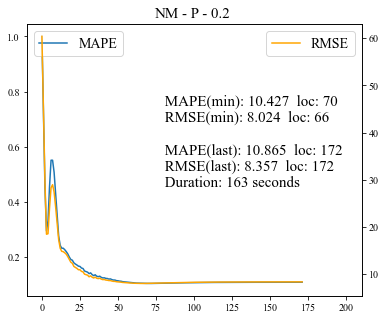

In [61]:
P_NM_(0.8)

### Experiments on Seattle Data Set

#### Random missing (RM) scenario

In [62]:
import scipy.io
import time
import pandas as pd

def S_RM_(ms):
    dense_mat = pd.read_csv('../datasets/Seattle-data-set/mat.csv', index_col = 0)
    RM_mat = pd.read_csv('../datasets/Seattle-data-set/RM_mat.csv', index_col = 0)
    dense_mat = dense_mat.values
    RM_mat = RM_mat.values
    dense_tensor = dense_mat.reshape([dense_mat.shape[0], 28, 288])
    RM_tensor = RM_mat.reshape([RM_mat.shape[0], 28, 288])

    ### Set the RM scenario by:
    binary_tensor = np.round(RM_tensor + 0.5 - missing_rate)
    # =============================================================================
    sparse_tensor = np.multiply(dense_tensor, binary_tensor)
    
    start = time.time()
    alpha = np.ones(3) / 3
    rho = 1e-5
    theta = 0.30
    epsilon = 1e-4
    maxiter = 200
    L, MAPE,RMSE = LRTC(dense_tensor, sparse_tensor, alpha, rho, theta, epsilon, maxiter)
    end = time.time()
    plot(RMSE,MAPE,'S',ms,'RM',end - start,)
    print('Running time: %d seconds'%(end - start))

Iter: 100
RMSE: 3.01208

Imputation MAPE: 0.0464732
Imputation RMSE: 3.05844

Running time: 119 seconds


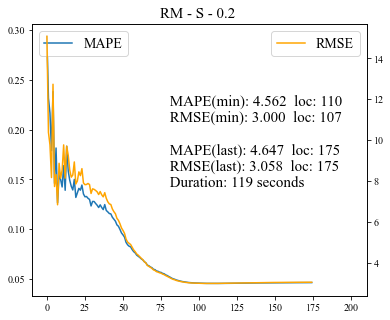

In [63]:
S_RM_(0.2)

Iter: 100
RMSE: 3.22163

Imputation MAPE: 0.0511641
Imputation RMSE: 3.30216

Running time: 130 seconds


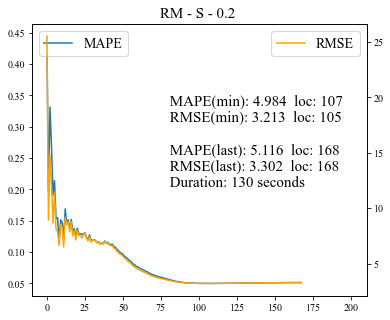

In [64]:
S_RM_(0.4)

Iter: 100
RMSE: 3.51862

Imputation MAPE: 0.0580412
Imputation RMSE: 3.66197

Running time: 133 seconds


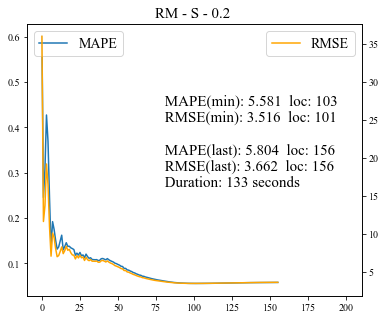

In [65]:
S_RM_(0.6)

Iter: 100
RMSE: 4.25866

Imputation MAPE: 0.0771843
Imputation RMSE: 4.6416

Running time: 156 seconds


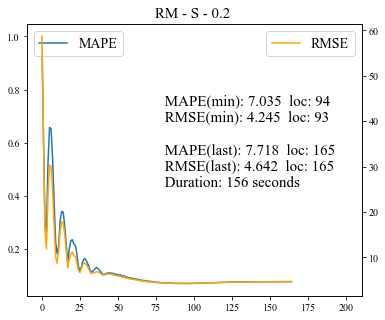

In [66]:
S_RM_(0.8)

#### Non-random missing (NM) scenario

In [67]:
import scipy.io
import time
import pandas as pd

def S_NM_(ms):
    dense_mat = pd.read_csv('../datasets/Seattle-data-set/mat.csv', index_col = 0).values
    dense_tensor = dense_mat.reshape([dense_mat.shape[0], 28, 288]).transpose(0, 2, 1)
    dim1, dim2, dim3 = dense_tensor.shape
    np.random.seed(1000)
    sparse_tensor = dense_tensor * np.round(np.random.rand(dim1, dim3) + 0.5 - missing_rate)[:, None, :]

    start = time.time()
    alpha = np.ones(3) / 3
    rho = 1e-5
    theta = 0.05
    epsilon = 1e-4
    maxiter = 200
    L, MAPE,RMSE = LRTC(dense_tensor, sparse_tensor, alpha, rho, theta, epsilon, maxiter)
    end = time.time()
    plot(RMSE,MAPE,'S',ms,'NM',end - start)
    print('Running time: %d seconds'%(end - start))

Iter: 100
RMSE: 4.27262

Imputation MAPE: 0.0706078
Imputation RMSE: 4.27989

Running time: 107 seconds


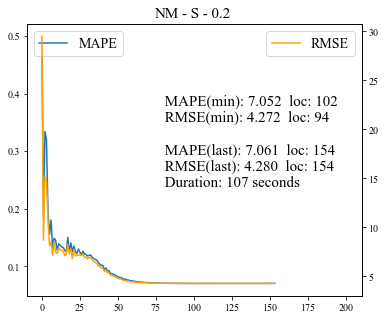

In [68]:
S_NM_(0.2)

Iter: 100
RMSE: 4.59134

Imputation MAPE: 0.0775267
Imputation RMSE: 4.6019

Running time: 119 seconds


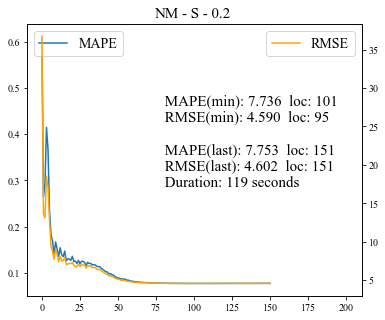

In [69]:
S_NM_(0.4)

Iter: 100
RMSE: 5.05745

Imputation MAPE: 0.0859971
Imputation RMSE: 5.06085

Running time: 130 seconds


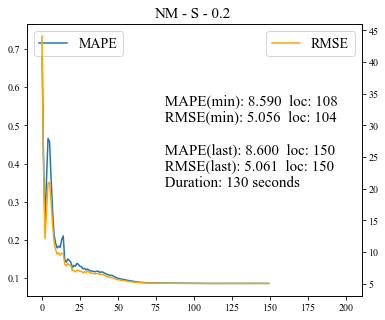

In [70]:
S_NM_(0.6)

Iter: 100
RMSE: 8.49718

Imputation MAPE: 0.115143
Imputation RMSE: 8.51636

Running time: 160 seconds


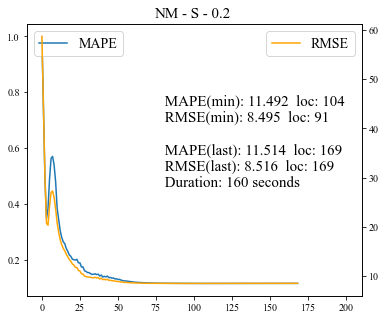

In [71]:
S_NM_(0.8)

### Experiments on Birmingham Data Set

#### Random missing (RM) scenario

In [73]:
import scipy.io
def B_RM_(ms):
    tensor = scipy.io.loadmat('../datasets/Birmingham-data-set/tensor.mat')
    dense_tensor = tensor['tensor']
    random_tensor = scipy.io.loadmat('../datasets/Birmingham-data-set/random_tensor.mat')
    random_tensor = random_tensor['random_tensor']

    # =============================================================================
    ### Random missing (RM) scenario
    ### Set the RM scenario by:
    binary_tensor = np.round(random_tensor + 0.5 - missing_rate)
    # =============================================================================
    sparse_tensor = np.multiply(dense_tensor, binary_tensor)

    import time
    start = time.time()
    alpha = np.ones(3) / 3
    rho = 1e-5
    theta = 0.15
    epsilon = 1e-4
    maxiter = 200
    L, MAPE,RMSE = LRTC(dense_tensor, sparse_tensor, alpha, rho, theta, epsilon, maxiter)
    end = time.time()
    plot(RMSE,MAPE,'B',ms,'RM',end - start)
    print('Running time: %d seconds'%(end - start))

Iter: 100
RMSE: 15.4334

Imputation MAPE: 0.0475487
Imputation RMSE: 15.4514

Running time: 0 seconds


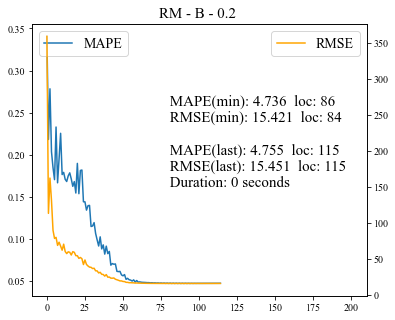

In [74]:
B_RM_(0.2)

Iter: 100
RMSE: 19.7243

Imputation MAPE: 0.0555532
Imputation RMSE: 19.7499

Running time: 0 seconds


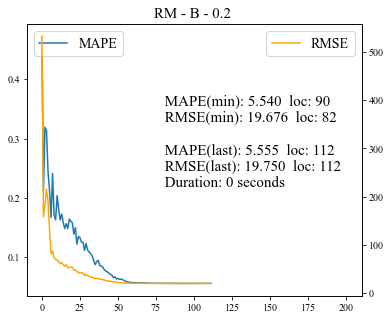

In [75]:
B_RM_(0.4)

Iter: 100
RMSE: 27.1879

Imputation MAPE: 0.076155
Imputation RMSE: 27.1492

Running time: 0 seconds


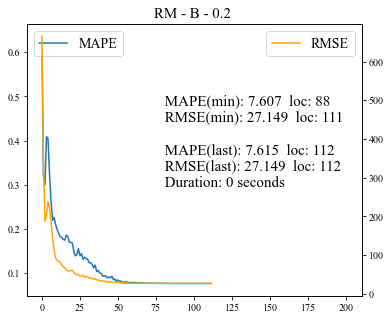

In [76]:
B_RM_(0.6)

Iter: 100
RMSE: 40.2066

Imputation MAPE: 0.10588
Imputation RMSE: 40.2376

Running time: 1 seconds


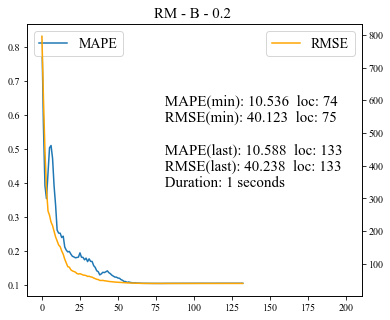

In [77]:
B_RM_(0.8)

#### Non-random missing (NM) scenario

In [85]:
import scipy.io
def B_NM_(ms):
    dense_tensor = scipy.io.loadmat('../datasets/Birmingham-data-set/tensor.mat')['tensor'].transpose(0, 2, 1)
    dim1, dim2, dim3 = dense_tensor.shape
    np.random.seed(1000)
    sparse_tensor = dense_tensor * np.round(np.random.rand(dim1, dim3) + 0.5 - missing_rate)[:, None, :]
    

    import time
    start = time.time()
    alpha = np.ones(3) / 3
    rho = 1e-5
    theta = 0.05
    epsilon = 1e-4
    maxiter = 200
    L, MAPE,RMSE = LRTC(dense_tensor, sparse_tensor, alpha, rho, theta, epsilon, maxiter)
    end = time.time()
    plot(RMSE,MAPE,'B',ms,'NM',end - start)
    print('Running time: %d seconds'%(end - start))

Imputation MAPE: 0.0808867
Imputation RMSE: 48.9284

Running time: 0 seconds


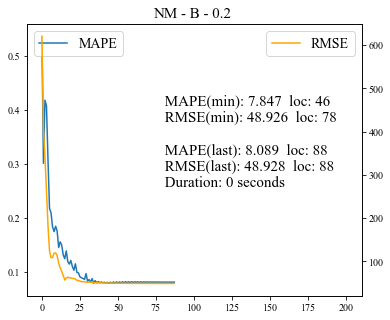

In [86]:
B_NM_(0.2)

Imputation MAPE: 0.105277
Imputation RMSE: 61.1769

Running time: 0 seconds


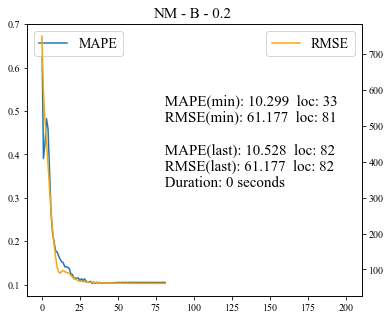

In [87]:
B_NM_(0.4)

Imputation MAPE: 0.166525
Imputation RMSE: 108.914

Running time: 0 seconds


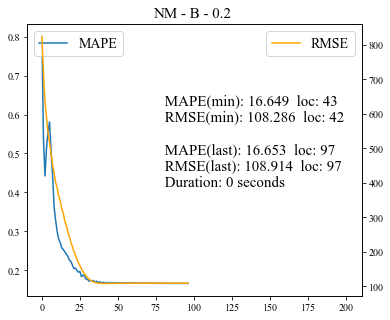

In [88]:
B_NM_(0.6)

Iter: 100
RMSE: 591.218

Imputation MAPE: 0.35843
Imputation RMSE: 591.104

Running time: 0 seconds


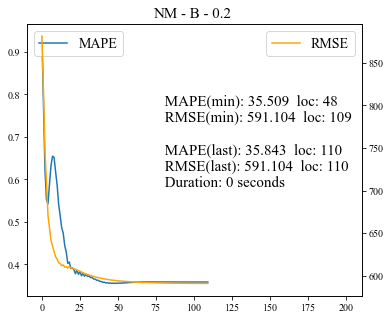

In [89]:
B_NM_(0.8)